In [1]:
%load_ext autoreload
%autoreload 2

import pickle
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from src.data.utils import flatten, parallelize_dataframe
from src.data.ambiguity2final import assign_emojipedia_category, assign_our_category
from src.data.scrape_emojipedia_categories import EMOJI_CATEGORIES as emoji_categories
from src.analysis.variation import calculate_vocabulary_variation
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter
from settings import AMBIGUITY_VARIATION, TWITTER_COUNTS,\
            BASELINE_VARIATION, BASELINE_VARIATION_CIs, BASELINE_VOCAB_SIZE, BASELINE_VOCAB_SIZE_CIs

pd.set_option('mode.chained_assignment', None)

sns.set_color_codes()
sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.7)
sns.set_style("white", {'axes.grid' : False})

### READ in with pre computed CIs

In [2]:
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)
variations.head()

,emoji,vocabulary,variation,mode_embedding,CIs
0,#️⃣,"Counter({'pound': 10, 'number': 9, 'hashtag': ...",0.496355,[-9.0013e-01 -4.3639e-03 4.7695e-01 1.4165e-...,"[0.35837585716197884, 0.6267261994754275]"
1,*️⃣,"Counter({'asterisk': 11, 'star': 9, 'pound': 2...",0.584016,[ 4.6689e-02 -2.3131e-01 6.4926e-01 -2.9223e-...,"[0.41200086324362406, 0.7542600946038873]"
2,©️,"Counter({'copyright': 17, 'copywrite': 3, 'c':...",0.276658,[-0.10602 -0.010289 -0.25982 0.52433 ...,"[0.1401009645106064, 0.4201737316739228]"
3,®️,"Counter({'r': 7, 'registered': 3, 'copyright':...",0.576165,[ 3.6664e-01 -4.0631e-01 2.3680e-01 2.9964e-...,"[0.4139707032711831, 0.7217792813700658]"
4,‼️,"Counter({'exclamation': 11, 'important': 3, 's...",0.494922,[ 0.80197 -1.3284 0.83488 -0.13458 ...,"[0.3517648566963858, 0.6258342967978838]"


In [3]:
variations.vocabulary = variations.vocabulary.apply(lambda x: x[8:-1])
variations.vocabulary = variations.vocabulary.apply(eval)
variations['vocabulary size'] = variations.vocabulary.apply(len)

In [4]:
variations["category"] = variations.emoji.apply(assign_emojipedia_category)
variations = variations[variations.category != "flags"]
variations = variations[~variations.emoji.isin(["🅰️", "🅱️", "🅾️", "🅿️", "🔟"])]
families = ["👨‍👦","👨‍👦‍👦","👨‍👧","👨‍👧‍👦","👨‍👧‍👧","👨‍👨‍👦","👨‍👨‍👦‍👦","👨‍👨‍👧","👨‍👨‍👧‍👦",\
"👨‍👨‍👧‍👧","👨‍👩‍👦","👨‍👩‍👦‍👦","👨‍👩‍👧","👨‍👩‍👧‍👦","👨‍👩‍👧‍👧","👩‍👦","👩‍👦‍👦","👩‍👧",\
"👩‍👧‍👦","👩‍👧‍👧","👩‍👩‍👦","👩‍👩‍👦‍👦","👩‍👩‍👧","👩‍👩‍👧‍👦","👩‍👩‍👧‍👧", "👨‍👩‍👧", "👨‍👩‍👧‍👦", "👨‍👩‍👧‍👧", "👩‍👩‍👧‍👦"]
variations = variations[~variations.emoji.isin(families)]

In [5]:
variations[variations.variation == 0].emoji

209      🌈
277      🍎
326      🍿
448      🐄
474      🐝
492      🐯
533      👗
655      💄
795      🔑
852     🕷️
877     🗝️
1032     🚿
1132     🥄
1148     🥕
1164     🥥
1198     🦋
Name: emoji, dtype: object

In [6]:
len(variations[variations.variation == 0].emoji)

16

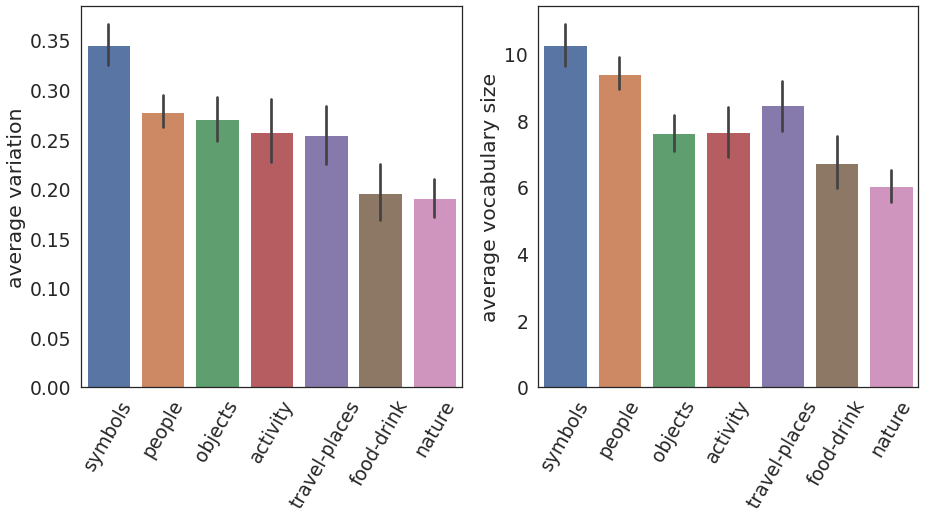

In [7]:
order = variations.groupby("category").variation.mean().sort_values(ascending=False).index.tolist()

rotation = 60
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
sns.barplot(x='category', y='variation', data=variations, ax=ax1, order=order)
ax1.tick_params(axis='x', rotation=rotation)
ax1.set_ylabel("average variation")

sns.barplot(x='category', y='vocabulary size', data=variations, ax=ax2, order=order)
ax2.tick_params(axis='x', rotation=rotation)
ax2.set_ylabel("average vocabulary size")
ax1.set_xlabel("")
ax2.set_xlabel("");

In [8]:
japanese = ['🈂️','🈚','🈯','🈲','🈳','🈴','🈵','🈶','🈷️','🈸',\
               '🈹','🈺','🉐','🉑','㊗️','㊙️','🀄']
astrological = ['♈','♉','♊','♋','♌','♍','♎','♏','♐','♑','♒','♓', '⛎']
religious = ['🕉️', '🕎', '☦️','☪️','☯️', '✝️','✡️']
hearts = ['💓','💔','💕','💖','💗','💘','💙','💚','💛','💜','💝','💞','💟']


others = set(variations[variations.category == "symbols"].emoji.unique()) \
                - set(japanese) - set(astrological) - set(religious) - set(hearts)

symbols_subcategories = {"Japanese": japanese, "astrological": astrological,\
                        "religious": religious, "hearts": hearts, "others": others}

In [9]:
symbols_df = variations[variations.category == "symbols"]

def assign_subcategory(emoji):
    for subcategory in symbols_subcategories:
        if emoji in symbols_subcategories[subcategory]:
            return subcategory

symbols_df["subcategory"] = symbols_df.emoji.apply(assign_subcategory)

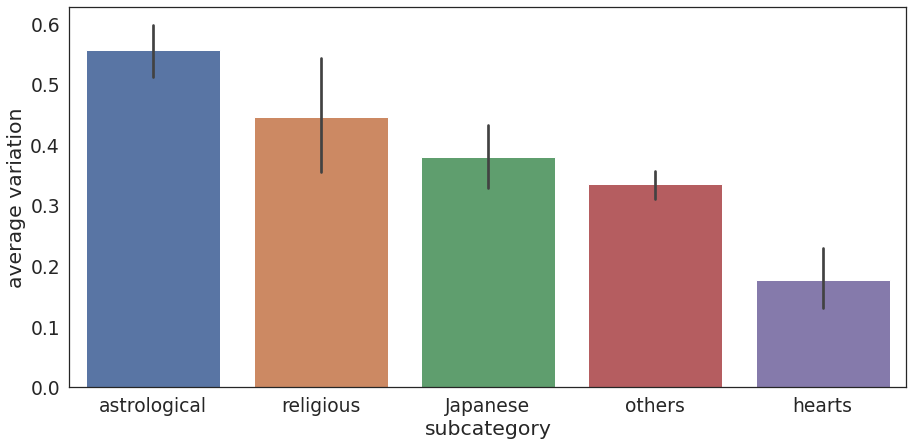

In [10]:
order = symbols_df.groupby("subcategory").variation.mean().sort_values(ascending=False).index.tolist()

fig, ax = plt.subplots()
sns.barplot(x='subcategory', y='variation', data=symbols_df, ax=ax, order=order)
ax.set_ylabel("average variation");

In [11]:
variations["category"] = variations.apply(assign_our_category, axis=1)
variations = variations.replace({"symbols": "symbols & signs"})

In [12]:
sns.set(rc={'figure.figsize':(8, 16)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})

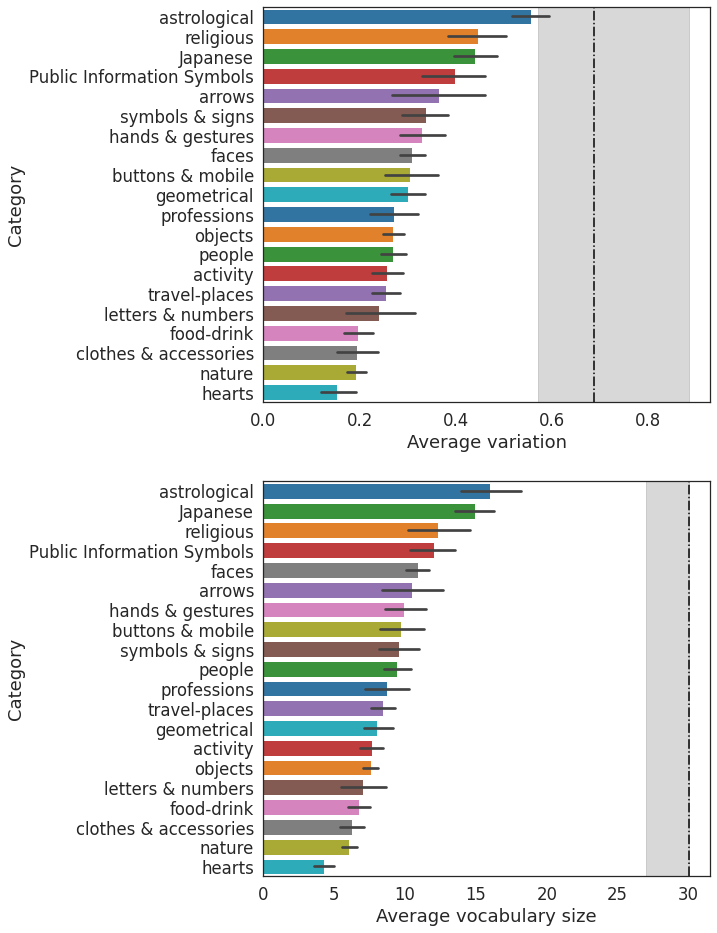

In [13]:
sns.set_palette("tab10", 20)

order1 = variations.groupby("category").variation.mean().sort_values(ascending=False).index.tolist()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
sns.barplot(y='category', x='variation', data=variations, ax=ax1, order=order1)
ax1.set_ylabel("Category")
ax1.set_xlabel("Average variation")

ax1.axvline(BASELINE_VARIATION, color='black', linestyle='-.')
ax1.axvspan(BASELINE_VARIATION_CIs[0],
             BASELINE_VARIATION_CIs[1], alpha=0.3, color='gray')



order2 = variations.groupby("category")["vocabulary size"].mean().sort_values(ascending=False).index.tolist()
pal = sns.color_palette()
color_map = dict(zip(order1, pal.as_hex()))
palette = [color_map[bar] for bar in order2]

sns.barplot(y='category', x='vocabulary size', data=variations, ax=ax2, order=order2, palette=palette)
ax2.set_ylabel("Category")
ax2.set_xlabel("Average vocabulary size")

ax2.axvline(BASELINE_VOCAB_SIZE, color='black', linestyle='-.')
ax2.axvspan(BASELINE_VOCAB_SIZE_CIs[0],
             BASELINE_VOCAB_SIZE_CIs[1], alpha=0.3, color='gray');

plt.savefig('../figures/emojiCategories.png', dpi=300, transparent=False, bbox_inches='tight');

In [14]:
variations[variations.emoji == '🚶'].category

1023    people
Name: category, dtype: object

In [15]:
variations.groupby("category").emoji.count().sort_values(ascending=False)

category
objects                       202
nature                        189
travel-places                 129
food-drink                    113
faces                         111
people                        103
activity                       78
clothes & accessories          47
symbols & signs                43
professions                    38
geometrical                    34
hands & gestures               34
Japanese                       34
buttons & mobile               29
Public Information Symbols     26
letters & numbers              21
hearts                         19
arrows                         16
astrological                   13
religious                      10
Name: emoji, dtype: int64

## Categories vs frequency

In [16]:
twitter_count = pd.read_csv(TWITTER_COUNTS)
variations = pd.merge(variations, twitter_count, on='emoji', how='left').rename({"count": "twitter_count"}, axis=1)

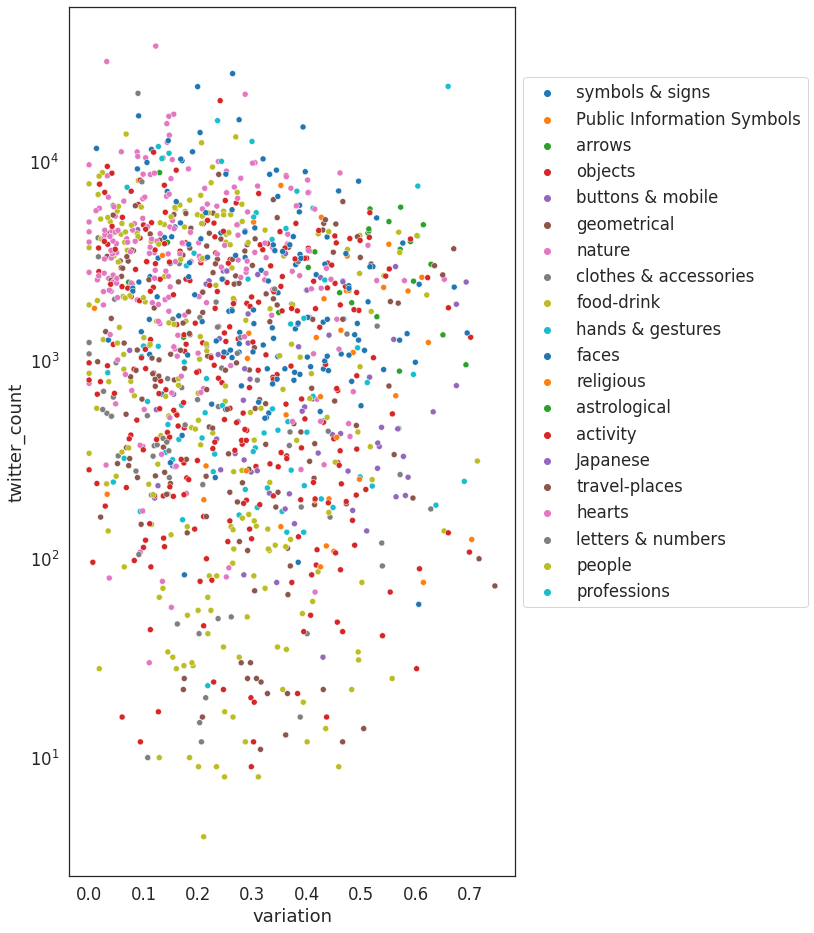

In [17]:
g = sns.scatterplot(data=variations, x='variation', y='twitter_count', hue='category')
g.set_yscale("log")
plt.legend(bbox_to_anchor=(1, 0.3), loc='lower left')

In [18]:
variations[['category', 'variation', 'twitter_count']].groupby("category").corr()

variation  twitter_count
category                                                          
Japanese                   variation       1.000000       0.095943
                           twitter_count   0.095943       1.000000
Public Information Symbols variation       1.000000       0.037204
                           twitter_count   0.037204       1.000000
activity                   variation       1.000000      -0.407787
                           twitter_count  -0.407787       1.000000
arrows                     variation       1.000000      -0.618261
                           twitter_count  -0.618261       1.000000
astrological               variation       1.000000      -0.345790
                           twitter_count  -0.345790       1.000000
buttons & mobile           variation       1.000000      -0.287771
                           twitter_count  -0.287771       1.000000
clothes & accessories      variation       1.000000      -0.167369
                           twitter_count  -0.167369       1.000000
faces                      variation       1.000000      -0.247983
                           twitter_count  -0.247983       1.000000
food-drink                 variation       1.000000      -0.137100
                           twitter_count  -0.137100       1.000000
geometrical                variation       1.000000       0.197344
                           twitter_count   0.197344       1.000000
hands & gestures           variation       1.000000      -0.017590
                           twitter_count  -0.017590       1.000000
hearts                     variation       1.000000      -0.229952
                           twitter_count  -0.229952       1.000000
letters & numbers          variation       1.000000      -0.232720
                           twitter_count  -0.232720       1.000000
nature                     variation       1.000000      -0.053479
                           twitter_count  -0.053479       1.000000
objects                    variation       1.000000      -0.062580
                           twitter_count  -0.062580       1.000000
people                     variation       1.000000      -0.133973
                           twitter_count  -0.133973       1.000000
professions                variation       1.000000      -0.480729
                           twitter_count  -0.480729       1.000000
religious                  variation       1.000000      -0.370365
                           twitter_count  -0.370365       1.000000
symbols & signs            variation       1.000000      -0.323001
                           twitter_count  -0.323001       1.000000
travel-places              variation       1.000000      -0.077788
                           twitter_count  -0.077788       1.000000

In [19]:
for category in variations.category.unique():
    print(f"Category: {category}")
    category_df = variations[variations.category == category]
    corr, p_value = spearmanr(category_df.variation.values, category_df.twitter_count.values, nan_policy='omit')
    print(corr, p_value)
    if abs(corr) > 0.4  and p_value < 0.05:
        print("HERE")
    print()

Category: symbols & signs
-0.3750871080139373 0.015674307762532775

Category: Public Information Symbols
0.014017094017094016 0.9458163483898879

Category: arrows
-0.6205882352941177 0.010313515549677674
HERE

Category: objects
-0.0672026660930716 0.341971647536492

Category: buttons & mobile
-0.2669950738916256 0.16147272541272206

Category: geometrical
-0.010087116473075163 0.9548488513588442

Category: nature
-0.07003350186481927 0.3382692219988458

Category: clothes & accessories
-0.2351478709317156 0.11159081399760104

Category: food-drink
-0.10871124778970334 0.25172560409319766

Category: hands & gestures
-0.147135217723453 0.40632329884882123

Category: faces
-0.20065461852868866 0.03471881626362736

Category: religious
-0.10303030303030303 0.7769984634438898

Category: astrological
-0.2802197802197803 0.35376363563367896

Category: activity
-0.36812554534073516 0.0009132557748983075

Category: Japanese
0.030710466004583648 0.8631123148395858

Category: travel-places
-0.1384894

## Gender vs category

In [20]:
from settings import FINAL_DF, EMBEDDINGS_PATH, DEMOGRAPHICS_PATH

from collections import Counter

from src.analysis.variation import calculate_vocabulary_variation, embedded_CIs
from src.analysis.variation import read_embeddings

In [21]:
demographics = pd.read_csv(DEMOGRAPHICS_PATH)
demographics.head()

,WorkerID,Age,Gender,Mothertongue
0,A10EQASJQODBUH,57.0,Female,english
1,A10T0161B70BXP,24.0,Male,english
2,A10VA2IF9D0HRI,39.0,Female,english
3,A11JBM10TZJGK7,24.0,Female,english
4,A11LSO6D7BMY99,59.0,Female,english


In [22]:
df = pd.read_csv(FINAL_DF, encoding='utf-8')
df.head()

,WorkerID,FormId,Duration,emoji_index,emoji,word,category,twitter_count
0,A19AAMLW7OP5V4,65,330.0,0,#️⃣,ash,symbols & signs,0.0
1,A1DD23J1WBGQUU,65,315.0,0,#️⃣,hashtag,symbols & signs,0.0
2,A2C7A6E70NYNUI,65,317.0,0,#️⃣,hashtag,symbols & signs,0.0
3,A2CK0OXMPOR9LE,65,521.0,0,#️⃣,pound,symbols & signs,0.0
4,A272X64FOZFYLB,65,329.0,0,#️⃣,pound,symbols & signs,0.0


In [23]:
df1 = pd.merge(df, demographics[['WorkerID', 'Age', 'Gender']], on='WorkerID')
females, males = df1[df1.Gender == 'Female'], df1[df1.Gender == 'Male']

In [24]:
def get_variation(df):
    print("Reading data...")
    word_embeddings = read_embeddings(EMBEDDINGS_PATH)

    print("Preprocessing...")
    vocabs = df[["emoji", "word"]] \
        .groupby("emoji").word \
        .apply(list).apply(Counter) \
        .reset_index() \
        .rename({"word": "vocabulary"}, axis=1)

    print("Calculating semantic variation in embedding space per emoji...")
    vocabs[["variation", "mode_embedding"]] = vocabs.apply(lambda row:
                                                                       calculate_vocabulary_variation(row.vocabulary,
                                                                                                      word_embeddings),
                                                                       axis=1,
                                                                       result_type='expand')
    return vocabs

In [25]:
female_vocabs, male_vocabs = get_variation(females), get_variation(males)
female_vocabs['annotators'] = 'females'
male_vocabs['annotators'] = 'males'

female_vocabs = female_vocabs.set_index("emoji")
male_vocabs = male_vocabs.set_index("emoji")

female_vocabs["mean_duration"] = females.groupby("emoji").Duration.sum() / females.groupby("emoji").WorkerID.count()
male_vocabs["mean_duration"] = males.groupby("emoji").Duration.sum() / males.groupby("emoji").WorkerID.count()

female_vocabs['vocabulary size'] = female_vocabs.vocabulary.apply(len)
male_vocabs['vocabulary size'] = male_vocabs.vocabulary.apply(len)

df = pd.concat((female_vocabs, male_vocabs))
df.head()

Reading data...
Preprocessing...
Calculating semantic variation in embedding space per emoji...
Reading data...
Preprocessing...
Calculating semantic variation in embedding space per emoji...


,vocabulary,variation,mode_embedding,annotators,mean_duration,vocabulary size
emoji,,,,,,
#️⃣,"{'ash': 2, 'hashtag': 3, 'number': 3, 'pound': 4}",0.497959,"[-0.90013, -0.0043639, 0.47695, 0.014165, -0.8...",females,402.166667,4
*️⃣,"{'star': 4, 'asterisk': 6, 'number': 1, 'pound...",0.570165,"[0.046689, -0.23131, 0.64926, -0.29223, -0.172...",females,276.800000,6
©️,"{'copywrite': 1, 'copyright': 10, 'c': 1, 'cor...",0.279054,"[-0.10602, -0.010289, -0.25982, 0.52433, 0.223...",females,241.937500,7
®️,"{'r': 5, 'rest': 1, 'restricted': 1, 'right': ...",0.544867,"[0.36664, -0.40631, 0.2368, 0.029964, 0.27124,...",females,271.176471,11
‼️,"{'important': 1, 'urgent': 1, 'punctuation': 1...",0.464738,"[0.80197, -1.3284, 0.83488, -0.13458, 0.1024, ...",females,222.294118,11


In [26]:
df = df.reset_index()
df["category"] = df.emoji.apply(assign_emojipedia_category)
df = df[df.category != "flags"]

df["category"] = df.apply(assign_our_category, axis=1)
df = df.replace({"symbols": "symbols & signs"})

/home/jczestochowska/.virtualenvs/base/lib/python3.6/site-packages/pandas/core/internals/managers.py:1985: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  op = lambda x: operator.eq(x, b)


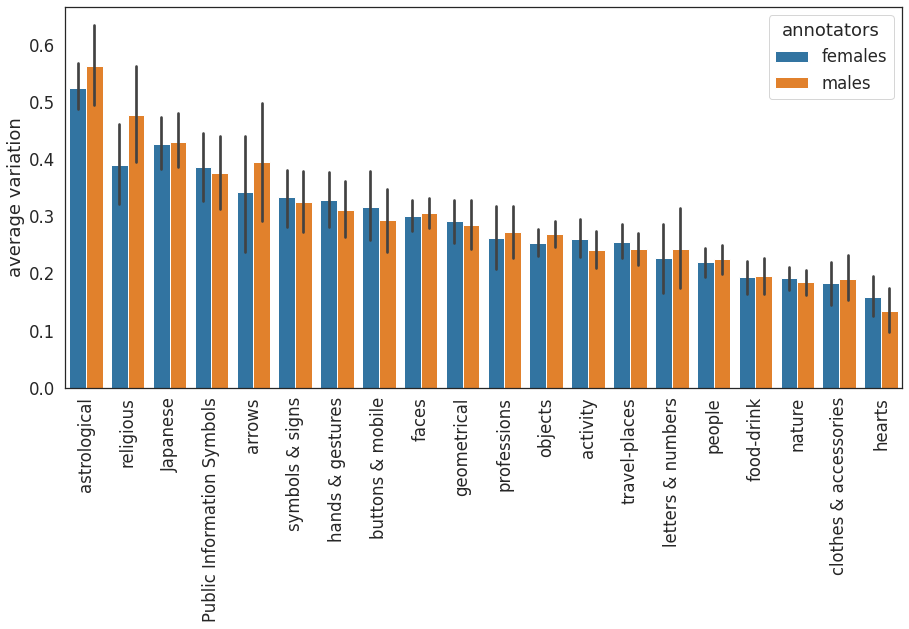

In [27]:
sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})
sns.set_palette("tab10", 20)

order1 = df.groupby("category").variation.mean().sort_values(ascending=False).index.tolist()

fig, ax1 = plt.subplots(nrows=1, ncols=1)
sns.barplot(x='category', y='variation', hue='annotators', data=df, ax=ax1, order=order1)
ax1.set_ylabel("average variation")
ax1.tick_params('x', rotation=90)
ax1.set_xlabel("");